#  Сегментация изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation/data
* https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
* https://amaarora.github.io/posts/2020-09-13-unet.html
* https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
* https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8
* https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* https://huggingface.co/docs/transformers/model_doc/segformer
* https://www.kaggle.com/code/damianpanek/segformerb0-people-clothing-segmentation

## Задачи для совместного разбора

1\. Рассмотрите пример работы слоя `ConvTranspose2d`.

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
img = th.arange(16).view(1, 1, 4, 4).float()
conv = nn.Conv2d(1, 1, kernel_size=3)
conv(img)

tensor([[[[0.8115, 1.6879],
          [4.3170, 5.1934]]]], grad_fn=<ConvolutionBackward0>)

In [ ]:
img = th.arange(4).view(1, 1, 2, 2).float()
conv_t = nn.ConvTranspose2d(1, 1, kernel_size=3)
conv_t(img)

tensor([[[[-0.3211, -0.1573, -0.5896, -0.4943],
          [ 0.0064, -0.4153, -1.5423, -0.6228],
          [-0.4180, -0.6422,  0.0133,  0.2892],
          [-0.3958, -0.2212, -0.0906, -0.4523]]]],
       grad_fn=<ConvolutionBackward0>)

## Задачи для самостоятельного решения

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchmetrics

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/данные/archive (1).zip') as ZIP:
  ZIP.extractall()

In [ ]:
import pandas as pd
import os
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchmetrics as M
from PIL import Image
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader, random_split

<p class="task" id="1"></p>

1\. Опишите датасет `ClothesSegmentationDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал два элемента: тензор с изображением и тензор с маской. Маска должна быть представлена трехмерным тензором целых чисел. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений и масок. Создайте объект датасета и выведите на экран форму и типы одного изображения и его маски.

- [ ] Проверено на семинаре

In [ ]:
class ClothesSegmentationDataset:
  def __init__(self, root_jpg, root_mask, transforms):
    self.root_jpg = root_jpg
    self.root_mask = root_mask
    self.images = os.listdir(root_jpg)
    self.masks = os.listdir(root_mask)
    self.transforms_img = transforms[0]
    self.transforms_mask = transforms[1]

  def __getitem__(self, idx):
    file_ = self.images[idx]
    mask = file_.replace('img', 'seg')
    img = Image.open(f"{self.root_jpg}/{file_}")
    mask = Image.open(f'{self.root_mask}/{mask}')
    img_t = self.transforms_img(img)
    mask_t = self.transforms_mask(mask)
    return img_t.float(), mask_t

  def __len__(self):
    return len(self.images)

In [ ]:
dataset = ClothesSegmentationDataset(
    "/content/jpeg_images/IMAGES",
    "/content/jpeg_masks/MASKS",
    [
        T.Compose([
          T.PILToTensor()
        ]),
        T.Compose([
            T.PILToTensor()
        ])
    ]
)
dataset[0][0].shape, dataset[0][1].shape, type(dataset[0][0]), type(dataset[0][1])

(torch.Size([3, 825, 550]),
 torch.Size([1, 825, 550]),
 torch.Tensor,
 torch.Tensor)

<p class="task" id="2"></p>

2\. Напишите функцию `show_image_with_mask`, которая выводит рядом два изображения: фотографию и маску. Продемонстрируйте работу функции, взяв один пример из созданного датасета.

- [ ] Проверено на семинаре

In [ ]:
def show_image_with_mask(image, mask):
  fig, ax = plt.subplots(ncols=2)
  ax[0].imshow(T.ToPILImage()(image / 255))
  ax[1].imshow(T.ToPILImage()(mask / 255))
  ax[0].axis('off')
  ax[1].axis('off')
  plt.show();

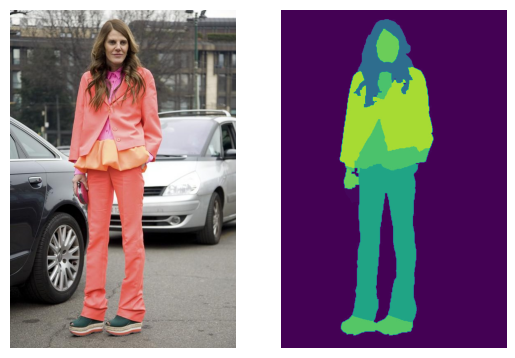

In [ ]:
show_image_with_mask(*dataset[0]);

<p class="task" id="3"></p>

3\. Реализуйте архитектуру U-Net. Реализуйте модель таким образом, чтобы на выходе для каждого изображения получался тензор размера `n_classes x h x w`, где `n_classes` - количество уникальных значений в масках, а `h` и `w` - размер исходного изображения. Возьмите один пример из набора данных и пропустите его через сеть. Выведите форму полученного результата на экран.

- [ ] Проверено на семинаре

In [ ]:
import torch.nn.functional as F

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)

    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs):
        super().__init__()
        self.chs        = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = th.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = T.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,16,32,64), dec_chs=(64, 32, 16), num_class=1):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)

    def forward(self, x):
        out_size = x.shape[2:]
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        out      = F.interpolate(out, out_size)
        return out

In [ ]:
model = UNet(num_class=59)

In [ ]:
out = model(dataset[0][0].unsqueeze(0))
out.shape

torch.Size([1, 59, 825, 550])

<p class="task" id="4"></p>

4\.  Разбейте набор данных на обучающее и валидационное множество. Обучите модель U-Net для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Обратите внимание, что выборка является несбалансированной. При расчете функции потерь примените любую известную вам технику для работы с несбалансированными выборками.

При создании датасета допускается использовать преобразования, уменьшающие размер изображений (для ускорения процесса обучения).

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [ ]:
transforms = T.Compose([
    T.Resize((200, 200)),
    T.PILToTensor()
])
dset = ClothesSegmentationDataset(
    "/content/jpeg_images/IMAGES",
    "/content/jpeg_masks/MASKS",
    transforms=[transforms, transforms]
)
train, test = random_split(dset, [0.8, 0.2])
train_loader = DataLoader(train, batch_size=8, shuffle=True)
test_loader = DataLoader(test, batch_size=8)

In [ ]:
weights = {}
for X_b, y_b in train_loader:
  unique, counts = y_b.unique(return_counts=True)
  for i, cls in enumerate(unique):
    weights[cls.item()] = weights.get(cls, 0) + counts[i].item()
if weights.get(59) is not None:
  weights.pop(59)
len(weights)

59

In [ ]:
n_samples = sum(weights.values())
weights_class = th.tensor([n_samples / (59 * v) for v in weights.values()])
weights_class.shape

torch.Size([59])

In [ ]:
n_epoch = 5
lr = 0.001
DEVICE = 'cuda'
model = UNet(num_class=59)
model.to(device=DEVICE)
optimizer = optim.Adam(model.parameters(), lr)
crit = nn.CrossEntropyLoss(weights_class.to(device=DEVICE))

for epoch in range(1, n_epoch+1):
  model.train()
  acc_train = M.Accuracy(task='multiclass', num_classes=59)
  for X_b, y_b in train_loader:
    out = model(X_b.to(device=DEVICE))
    y_b = y_b.squeeze().long()
    loss = crit(out, y_b.to(device=DEVICE))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    acc_train.update(out.argmax(dim=1).detach().cpu(), y_b)
  model.eval()
  for X_b, y_b in test_loader:
    out = model(X_b.to(device=DEVICE))
    loss_test = crit(out, y_b.squeeze().long().to(device=DEVICE))
  print(f'{epoch=} loss_train={loss.item():.5f} loss_test={loss_test.item():.5f} acc_train={acc_train.compute()}')

epoch=1 loss_train=3.71499 loss_test=3.72735 acc_train=0.003501906292513013
epoch=2 loss_train=4.21364 loss_test=3.56475 acc_train=0.0039542498998343945
epoch=3 loss_train=3.37282 loss_test=3.57977 acc_train=0.00428521865978837
epoch=4 loss_train=3.58189 loss_test=3.51496 acc_train=0.005392968654632568
epoch=5 loss_train=3.85772 loss_test=3.47770 acc_train=0.0051590935327112675


In [ ]:
X, y = dataset[0]
X = X.unsqueeze(0)
X.shape, y.shape

(torch.Size([1, 3, 825, 550]), torch.Size([1, 825, 550]))

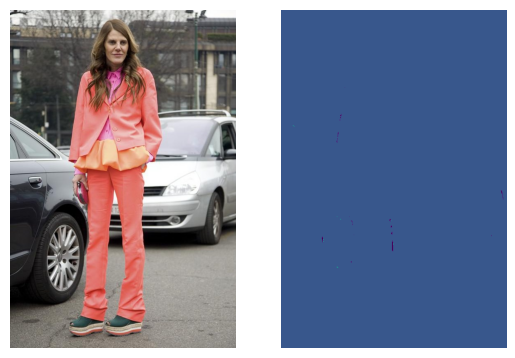

In [ ]:
out = model(X.to(device=DEVICE))
show_image_with_mask(X.squeeze(), out.cpu().detach().argmax(dim=1))

<p class="task" id="5"></p>

5\.  Обучите модуль `SegformerForSemanticSegmentation` из пакета `transformers` для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Для оптимизации используйте значение функции потерь, которое возвращает вам модель.

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [ ]:
from transformers import SegformerForSemanticSegmentation
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b5-finetuned-cityscapes-1024-1024",
    num_labels=60,
    ignore_mismatched_sizes=True
    )

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 768, 1, 1]) in the checkpoint and torch.Size([60, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([60]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.decode_head

SegformerDecodeHead(
  (linear_c): ModuleList(
    (0): SegformerMLP(
      (proj): Linear(in_features=64, out_features=768, bias=True)
    )
    (1): SegformerMLP(
      (proj): Linear(in_features=128, out_features=768, bias=True)
    )
    (2): SegformerMLP(
      (proj): Linear(in_features=320, out_features=768, bias=True)
    )
    (3): SegformerMLP(
      (proj): Linear(in_features=512, out_features=768, bias=True)
    )
  )
  (linear_fuse): Conv2d(3072, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batch_norm): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Conv2d(768, 60, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
from transformers import SegformerForSemanticSegmentation

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b5-finetuned-cityscapes-1024-1024",
    num_labels=60,
    ignore_mismatched_sizes=True
    )
model.requires_grad_(False)
model.decode_head.requires_grad_(True)
model = model.to(device='cuda')

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 5
for epoch in range(epochs):
    model.train()
    train_losses = []
    acc_m = torchmetrics.Accuracy(task="multiclass", num_classes=num_class)
    for image, mask in train_loader:
        out = model(image.float().to(device='cuda'), mask.squeeze().long().to(device='cuda'))

        loss = out.loss
        train_losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = F.interpolate(out.logits, size=(300, 200))

        acc_m.update(preds.argmax(dim=1).to(device='cpu'), mask.squeeze().long())

    print('train loss = ', th.tensor(train_losses).mean().item())
    print('train accuracy = ', acc_m.compute().item())
    model.eval()
    for image, mask in test_loader:
        out = model(image.float().to(device='cuda'), mask.squeeze().long().to(device='cuda'))

        preds = F.interpolate(out.logits, size=(300, 200))

        acc_m.update(preds.argmax(dim=1).to(device='cpu'), mask.squeeze().long())

    print('test accuracy = ', acc_m.compute().item())

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 768, 1, 1]) in the checkpoint and torch.Size([60, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([60]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train loss =  1.2396231889724731
train accuracy =  0.7588751912117004
test accuracy =  0.7704549431800842
train loss =  0.6890324950218201
train accuracy =  0.8277429938316345
test accuracy =  0.8287355899810791
train loss =  0.6256712675094604
train accuracy =  0.8385841846466064
test accuracy =  0.8379696011543274
train loss =  0.5926755666732788
train accuracy =  0.844558835029602
test accuracy =  0.8429450392723083
train loss =  0.5689679384231567
train accuracy =  0.8490563631057739
test accuracy =  0.8467012047767639


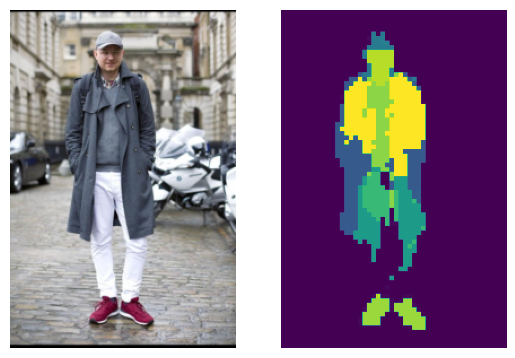

In [ ]:
img = dset[3][0]
mask = model(img.unsqueeze(dim=0).float().to(device='cuda'))
mask = F.interpolate(mask.logits, size=(300, 200))
show_image_with_mask(img, mask.argmax(dim=1).detach().cpu())

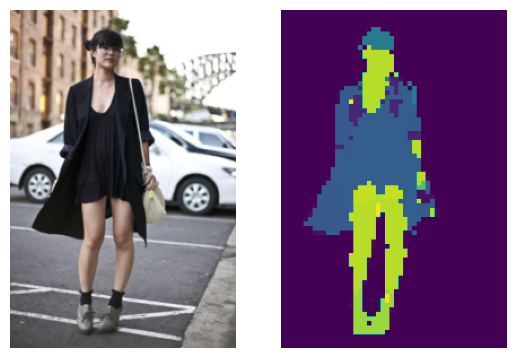

In [ ]:
img = dset[10][0]
mask = model(img.unsqueeze(dim=0).float().to(device='cuda'))
mask = F.interpolate(mask.logits, size=(300, 200))
show_image_with_mask(img, mask.argmax(dim=1).detach().cpu())

## Обратная связь
- [ ] Хочу получить обратную связь по решению